In [ ]:
import pandas as pd #We will be using this library for importing and manipulating data
pd.set_option('float_format', '{:f}'.format)
import plotly.express as graphs # We will be using this library for our data visualizations
import folium # We will be using this library for data visualizations as well
from folium.plugins import FastMarkerCluster
import re
from sklearn.model_selection import train_test_split
from nltk import FreqDist
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing import sequence,text
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gc
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from wordcloud import WordCloud
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Input**


In [ ]:
df = pd.read_csv('/content/drive/My Drive/project_data.csv') #df = pd.read_csv('/content/drive/My Drive/airbnb/airbnb_barbados.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (14,16) have mixed types.Specify dtype option on import or set low_memory=False.



#**Dataset Exploration**

In [ ]:
df.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,27,34.000000,beforeitsnews.com,fake,http://beforeitsnews.com/opinion-conservative/...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Surprise: Socialist Hotbed Of Venezuela Has Lo...,The Pirate'S Cove,nan,[''],NaN,NaN,nan,NaN
1,28,35.000000,beforeitsnews.com,fake,http://beforeitsnews.com/politics/2018/01/wate...,Water Cooler 1/25/18 Open Thread; Fake News ? ...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Water Cooler 1/25/18 Open Thread; Fake News ? ...,NaN,nan,[''],NaN,NaN,nan,NaN
2,29,36.000000,beforeitsnews.com,fake,http://beforeitsnews.com/politics/2018/01/vete...,Veteran Commentator Calls Out the Growing “Eth...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Veteran Commentator Calls Out the Growing “Eth...,NaN,nan,[''],NaN,NaN,nan,NaN
3,30,37.000000,beforeitsnews.com,fake,http://beforeitsnews.com/arts/2018/01/lost-wor...,"Lost Words, Hidden Words, Otters, Banks and Bo...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Lost Words, Hidden Words, Otters, Banks and Books",Jackie Morris Artist,nan,[''],NaN,NaN,nan,NaN
4,31,38.000000,beforeitsnews.com,fake,http://beforeitsnews.com/financial-markets/201...,Red Alert: Bond Yields Are SCREAMING “Inflatio...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Red Alert: Bond Yields Are SCREAMING “Inflatio...,Phoenix Capital Research,nan,[''],NaN,NaN,nan,NaN


In [ ]:
df.shape

(380702, 17)

In [ ]:
df.dtypes

Unnamed: 0            int64
id                  float64
domain               object
type                 object
url                  object
content              object
scraped_at           object
inserted_at          object
updated_at           object
title                object
authors              object
keywords            float64
meta_keywords        object
meta_description     object
tags                 object
summary             float64
source               object
dtype: object

In [ ]:
df.describe()

,Unnamed: 0,id,keywords,summary
count,380702.000000,380702.000000,0.000000,0.000000
mean,98399.213668,2952517.809946,nan,nan
std,162208.755399,3499612.049310,nan,nan
min,0.000000,6.000000,nan,nan
25%,3381.000000,579150.750000,nan,nan
50%,6810.000000,1292870.500000,nan,nan
75%,147844.000000,3426839.000000,nan,nan
max,426549.000000,9878253.000000,nan,nan


In [ ]:
text = df.dtypes[df.dtypes == "object"].index
text

Index(['domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at',
       'updated_at', 'title', 'authors', 'meta_keywords', 'meta_description',
       'tags', 'source'],
      dtype='object')

In [ ]:
df[text].describe()

,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,meta_keywords,meta_description,tags,source
count,380702,380702,380702,380702,380702,380702,380702,380660,271698,363570,129036,106795,94370
unique,176,5,379683,338963,94383,5,5,354925,33991,80959,121464,44621,2
top,beforeitsnews.com,fake,https://www.amren.com/news/2013/02/a-genetic-c...,This website uses profiling (non technical) co...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,portal.liberalamerica.org,"Sinclair Jenkins, Chris Roberts, Guillaume Dur...",[''],America’s Finest News Source,"4062 followers Duggar Family, 3756 followers S...",nytimes
freq,161169,168409,2,6593,146282,164003,164003,2600,25954,272482,3069,6019,77238


In [ ]:
df.type.value_counts()

fake         168409
reliable      96024
hate          46078
satire        43443
clickbait     26748
Name: type, dtype: int64

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'domain', 'type', 'url', 'content', 'scraped_at',
       'inserted_at', 'updated_at', 'title', 'authors', 'keywords',
       'meta_keywords', 'meta_description', 'tags', 'summary', 'source'],
      dtype='object')

#**Cleaning Dataset**

In [ ]:
df = df.drop(['Unnamed: 0', 'id', 'keywords', 'summary','meta_keywords', 'meta_description','tags', 'source'], axis=1)

In [ ]:
df.head()

,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors
0,beforeitsnews.com,fake,http://beforeitsnews.com/opinion-conservative/...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Surprise: Socialist Hotbed Of Venezuela Has Lo...,The Pirate'S Cove
1,beforeitsnews.com,fake,http://beforeitsnews.com/politics/2018/01/wate...,Water Cooler 1/25/18 Open Thread; Fake News ? ...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Water Cooler 1/25/18 Open Thread; Fake News ? ...,NaN
2,beforeitsnews.com,fake,http://beforeitsnews.com/politics/2018/01/vete...,Veteran Commentator Calls Out the Growing “Eth...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Veteran Commentator Calls Out the Growing “Eth...,NaN
3,beforeitsnews.com,fake,http://beforeitsnews.com/arts/2018/01/lost-wor...,"Lost Words, Hidden Words, Otters, Banks and Bo...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Lost Words, Hidden Words, Otters, Banks and Books",Jackie Morris Artist
4,beforeitsnews.com,fake,http://beforeitsnews.com/financial-markets/201...,Red Alert: Bond Yields Are SCREAMING “Inflatio...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Red Alert: Bond Yields Are SCREAMING “Inflatio...,Phoenix Capital Research


In [ ]:
df = df[df['authors'].notna()]

In [ ]:
df = df[df['title'].notna()]

In [ ]:
text = df.dtypes[df.dtypes == "object"].index
text
df[text].describe()

,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors
count,271697,271697,271697,271697,271697,271697,271697,271697,271697
unique,131,5,270690,242588,59455,5,5,260298,33991
top,beforeitsnews.com,fake,https://www.amren.com/news/2013/07/managed-mea...,This website uses profiling (non technical) co...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,American Renaissance,"Sinclair Jenkins, Chris Roberts, Guillaume Dur..."
freq,110473,111497,2,6593,100869,112896,112896,699,25954


In [ ]:
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = re.sub('[^a-zA-Z]',' ', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
df['clean'] = df['content'].apply(clean_text)
df.head()

,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,clean
0,beforeitsnews.com,fake,http://beforeitsnews.com/opinion-conservative/...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Surprise: Socialist Hotbed Of Venezuela Has Lo...,The Pirate'S Cove,headline bitcoin blockchain searches exceed tr...
3,beforeitsnews.com,fake,http://beforeitsnews.com/arts/2018/01/lost-wor...,"Lost Words, Hidden Words, Otters, Banks and Bo...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Lost Words, Hidden Words, Otters, Banks and Books",Jackie Morris Artist,lost words hidden words otters banks books rea...
4,beforeitsnews.com,fake,http://beforeitsnews.com/financial-markets/201...,Red Alert: Bond Yields Are SCREAMING “Inflatio...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Red Alert: Bond Yields Are SCREAMING “Inflatio...,Phoenix Capital Research,red alert bond yields screaming inflation comi...
5,beforeitsnews.com,fake,http://beforeitsnews.com/environment/2018/01/s...,Scientists move Doomsday Clock ahead by 30 sec...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Scientists move Doomsday Clock ahead by 30 sec...,Desdemona Despair,scientists move doomsday clock ahead seconds c...
8,coed.com,fake,https://coed.com/2018/01/22/college-basketball...,Every college basketball fan knows all too wel...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"College Basketball Rankings, Week 12: Top 25 P...","Avid Sports Fan, Writer. Huge Fan Of The Oriol...",every college basketball fan knows well preval...


In [ ]:
df['word'] = df['clean'].apply(lambda x: len((x).split()))

In [ ]:
df = df[df['word'] >= 1]
df = df.reset_index(drop=True)

#**Cluster Analysis Using K-means**

Word frequency of each Type (Sentiment) 

In [ ]:
sentiment = df.groupby('type')['word'].describe().reset_index()
sentiment

,type,count,mean,std,min,25%,50%,75%,max
0,clickbait,16142.000000,267.827717,253.651003,3.000000,131.000000,234.000000,359.000000,9508.000000
1,fake,111497.000000,282.473179,371.732984,4.000000,78.000000,182.000000,365.000000,13843.000000
2,hate,43416.000000,381.366547,772.826185,1.000000,137.000000,227.000000,366.000000,9209.000000
3,reliable,59785.000000,356.201254,332.084238,3.000000,152.000000,307.000000,473.000000,16788.000000
4,satire,40857.000000,136.402306,148.479234,3.000000,18.000000,52.000000,241.000000,9519.000000


In [ ]:
trainVec = TfidfVectorizer()
trainMatrix = trainVec.fit_transform(df['clean'])

In [ ]:
kmeans_model = MiniBatchKMeans(n_clusters=5, init='k-means++', n_init=1, init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(trainMatrix)
kmeans_clusters = kmeans.predict(trainMatrix)
kmeans_distances = kmeans.transform(trainMatrix)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = trainVec.get_feature_names()
df['cluster'] = list(kmeans.labels_)

In [ ]:
for i in range(5):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :10]:
        print(' %s' % terms[j])
    print()

Cluster 0:
 cookies
 use
 accessing
 navigation
 profiling
 banner
 preferences
 consent
 element
 user

Cluster 1:
 conspiracy
 blow
 proved
 congressional
 away
 hearing
 major
 fact
 event
 megadisaster

Cluster 2:
 percent
 market
 snip
 students
 said
 year
 school
 people
 million
 report

Cluster 3:
 said
 mr
 new
 snip
 police
 please
 york
 would
 people
 main

Cluster 4:
 blockchain
 us
 trump
 one
 com
 next
 new
 source
 day
 two



In [ ]:
cluster = df.groupby(['type','cluster'])['word'].describe().reset_index()
cluster

,type,cluster,count,mean,std,min,25%,50%,75%,max
0,clickbait,2,1405.000000,405.394306,326.735436,9.000000,241.000000,340.000000,472.000000,6824.000000
1,clickbait,3,1416.000000,384.620056,402.870513,6.000000,236.000000,320.000000,449.000000,9508.000000
2,clickbait,4,13321.000000,240.903386,212.836196,3.000000,99.000000,213.000000,332.000000,4643.000000
3,fake,1,2915.000000,24.510463,20.241375,8.000000,8.000000,8.000000,48.000000,102.000000
4,fake,2,18412.000000,486.271942,497.662151,7.000000,228.000000,377.500000,586.000000,9484.000000
5,fake,3,3308.000000,512.105502,680.604113,34.000000,75.750000,353.000000,621.250000,7971.000000
6,fake,4,86862.000000,239.186065,303.829578,4.000000,74.000000,155.000000,307.000000,13843.000000
7,hate,2,12770.000000,456.483712,850.784136,3.000000,171.000000,261.000000,413.000000,9158.000000
8,hate,3,19690.000000,419.094870,883.454547,5.000000,157.000000,240.000000,372.000000,9209.000000
9,hate,4,10956.000000,226.007211,295.376826,1.000000,58.000000,145.000000,281.000000,6552.000000


In [ ]:
s_a = df.groupby('cluster')['word'].describe().reset_index()
s_a

,cluster,count,mean,std,min,25%,50%,75%,max
0,0,6712.000000,9.021454,2.552822,5.000000,5.000000,10.000000,11.000000,11.000000
1,1,143593.000000,214.440864,251.207381,1.000000,70.000000,161.000000,278.000000,15139.000000
2,2,6593.000000,33.000000,0.000000,33.000000,33.000000,33.000000,33.000000,33.000000
3,3,2915.000000,24.510463,20.241375,8.000000,8.000000,8.000000,48.000000,102.000000
4,4,111884.000000,429.930124,584.532355,3.000000,190.000000,320.000000,492.000000,16788.000000


# Cluster Visualization


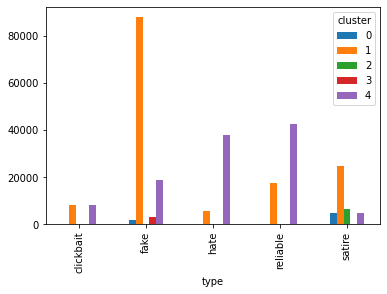

In [ ]:
df.groupby(['type','cluster'])['word'].count().unstack().plot(kind='bar', stacked=False)
plt.title("Word Count by Cluster and Type", fontsize =20)

Text(0.5, 1.0, 'Number of articles by cluster')

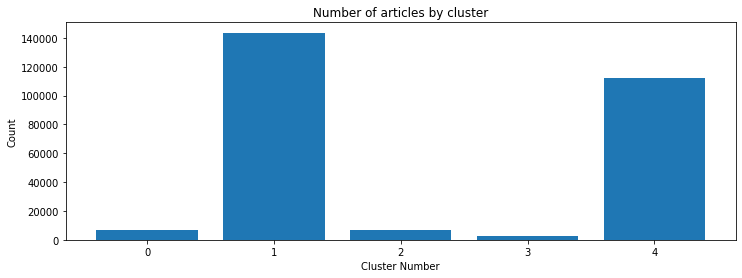

In [ ]:
plt.figure(figsize=(12,4))
plt.bar(df.cluster.value_counts().index, df.cluster.value_counts())
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.title('Number of articles by cluster')

In [ ]:
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
import matplotlib as plt
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

In [ ]:
trace1 = go.Bar(
    x=s_a['cluster'],
    y=s_a['count'] 
)

data = [trace1]
layout = go.Layout(
    title = 'Sentiment_Count'
)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="colab")


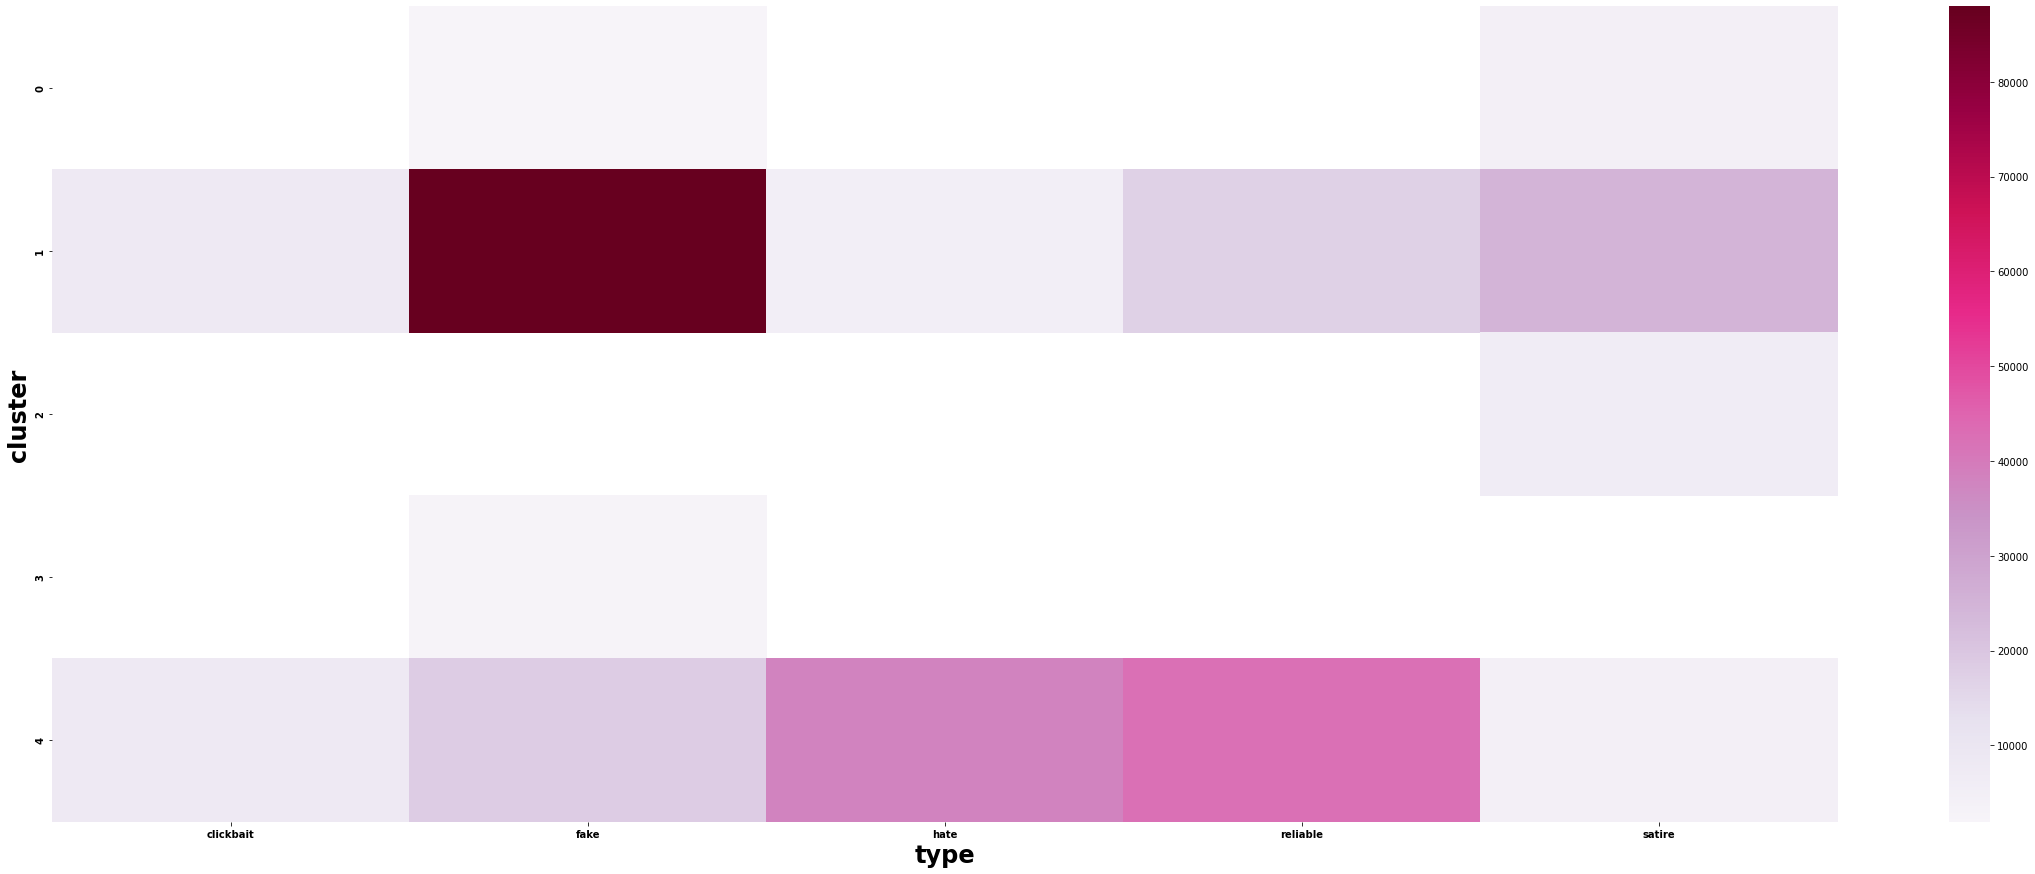

In [ ]:
clusters = df.groupby(['cluster', 'type']).size()
fig2, ax2 = plt.subplots(figsize = (40, 15))
sns.heatmap(clusters.unstack(level = 'type'), ax = ax2, cmap = 'PuRd')
plt.title("Heatmap of Cluster Correlation to Original Article Types", fontsize =20)
ax2.set_xlabel('type', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(10)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(10)
    label.set_weight("bold")

In [ ]:
from wordcloud import WordCloud
text = str(df[df['cluster'] == 0]['clean'].tolist())
text = text.lower()
wordcloud = WordCloud(max_words=50).generate(text)

labels = list(wordcloud.words_.keys())
values = list(wordcloud.words_.values())
trace = go.Pie(labels=labels, values=values,textinfo='value', hoverinfo='label+value',textposition = 'inside')
layout = go.Layout(
    title = 'Word Pie Plot for Cluster 0'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

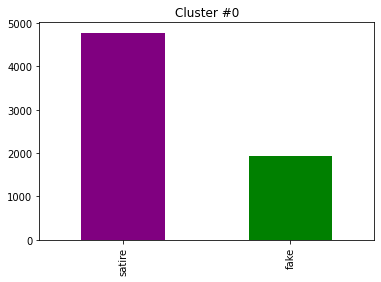

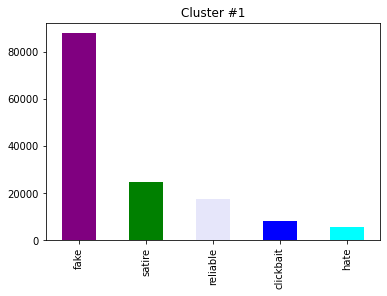

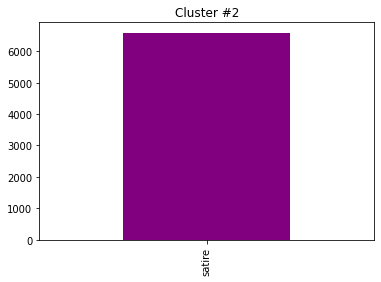

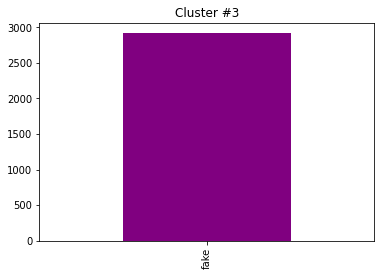

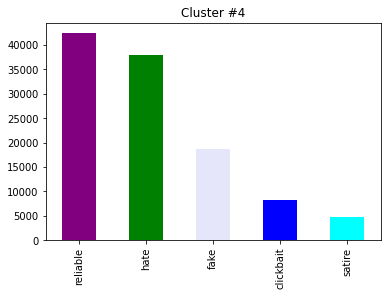

In [ ]:
def plot_cluster(c):
    df[kmeans_clusters == c]['type'].value_counts().plot(kind='bar',color=['purple', 'green', 'lavender', 'blue', 'cyan'], title="Cluster #{}".format(c))
    plt.show()


plot_cluster(0)
plot_cluster(1)
plot_cluster(2)
plot_cluster(3)
plot_cluster(4)

In [ ]:
del wordcloud
gc.collect()

244

In [ ]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df.cluster, kmeans.predict(trainMatrix))

1.0

In [ ]:
train, test = train_test_split(df)

# **Model training using LSTM**


In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
type_encoder = LabelEncoder()
train["type"] = type_encoder.fit_transform(train["type"])

train_text=train.filter(['clean','cluster'])
test_text=test.filter(['clean','cluster'])
target=train.type.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(203772, 2) (203772,) (203772, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(163017, 2) (163017, 5)
(40755, 2) (40755, 5)


In [ ]:
all_words=' '.join(X_train_text.clean.values)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)

In [ ]:
r_len=[]
for text in X_train_text.clean.values:
    word=text.split()
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)

In [ ]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 3
num_classes=5

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text.clean.values))
X_train = tokenizer.texts_to_sequences(X_train_text.clean.values)
X_val = tokenizer.texts_to_sequences(X_val_text.clean.values)
X_test = tokenizer.texts_to_sequences(test.clean.values)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 27.4 gigabytes of available RAM



In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=None)
X_val = sequence.pad_sequences(X_val, maxlen=None)
X_test = sequence.pad_sequences(X_test, maxlen=None)
print(X_train.shape,X_val.shape,X_test.shape)

(163017, 16788) (40755, 9998) (67925, 12413)


In [ ]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(max_features, EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(32, dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         39100000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 39,117,189
Trainable params: 39,117,189
Non-trainable params: 0
_________________________________________________________________
None


#Model Fit

In [ ]:
%%time
epochs = 3
batch_size = 32
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size,verbose=1)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
4585/4585 [==============================] - 3319s 720ms/step - loss: 0.5132 - accuracy: 0.8203 - val_loss: 0.2239 - val_accuracy: 0.9260
Epoch 2/3
4585/4585 [==============================] - 3294s 718ms/step - loss: 0.2015 - accuracy: 0.9363 - val_loss: 0.2196 - val_accuracy: 0.9333
Epoch 3/3
4585/4585 [==============================] - 3300s 720ms/step - loss: 0.1476 - accuracy: 0.9532 - val_loss: 0.2042 - val_accuracy: 0.9328
CPU times: user 4h 5min 37s, sys: 26min 11s, total: 4h 31min 48s
Wall time: 2h 45min 12s


In [ ]:
#model_save_name = 'LSTM_model2.pt'
#path = F"/content/drive/My Drive/{model_save_name}" 
#model.save(F"/content/drive/MyDrive/NEW_LSTM2.h5")

#**Model Test**

In [ ]:
predictions_test = model.predict_classes(X_val,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



1274/1274 [==============================] - 190s 148ms/step


In [ ]:
unique, counts = np.unique(predictions_test, return_counts=True)
dict(zip(unique, counts))

{0: 2297, 1: 16692, 2: 6463, 3: 8722, 4: 6581}

#Performance Metrics


In [ ]:
acc = model.evaluate(X_val,y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

1274/1274 [==============================] - 193s 151ms/step - loss: 0.2071 - accuracy: 0.9324
Test set
  Loss: 0.207
  Accuracy: 0.932


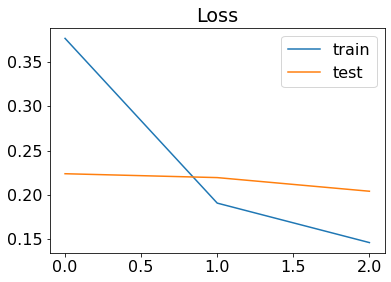

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

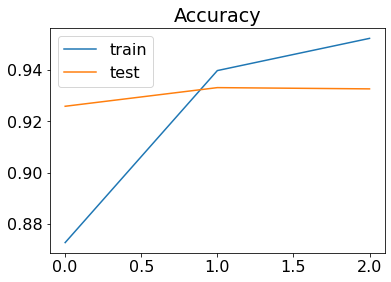

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision = precision_score(yx, predictions_test, average='weighted')
print("Model Precision : ", precision)

recall = recall_score(yx, predictions_test, average='weighted')
print("Model Recall Score : ", recall)

f1 = f1_score(yx, predictions_test, average='weighted')
print("Model F1 Score : ", f1)

Model Precision :  0.9330775100214844
Model Recall Score :  0.9324500061342167
Model F1 Score :  0.9325220578847031


**Single additional test**

In [ ]:
new_article = ['Headline: Bitcoin & Blockchain Searches Exceed Trump! Blockchain Stocks Are Next! Quite frankly']
seq = tokenizer.texts_to_sequences(new_article)
padded = sequence.pad_sequences(seq, maxlen=max_words)
pred = model.predict(padded)
labels = ["clickbait","fake","hate","reliable","satire"]
print(pred, labels[np.argmax(pred)])

[[1.1508184e-04 9.9953961e-01 9.1264279e-05 1.8954473e-04 6.4518077e-05]] fake


In [ ]:
yx = np.argmax(y_val, axis=1)
accuracy = accuracy_score(yx, predictions_test)
print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9324500061342167
